# HSIC Measures

In [1]:
import sys
sys.path.append("../../")

import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
# from jax.config import config
# config.update("jax_enable_x64", True)


# dependence measures
from jaxkern.similarity.hsic import HSIC, CKA
from jaxkern.kernels.linear import linear_kernel
from jaxkern.kernels.stationary import rbf_kernel
from jaxkern.kernels.utils import kernel_matrix
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.similarity.hsic import HSICRBFSampler, CKARBFSampler
from jaxkern.kernels.approx import RBFSampler
from jaxkern.kernels.sigma import estimate_sigma_median

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Toy Data

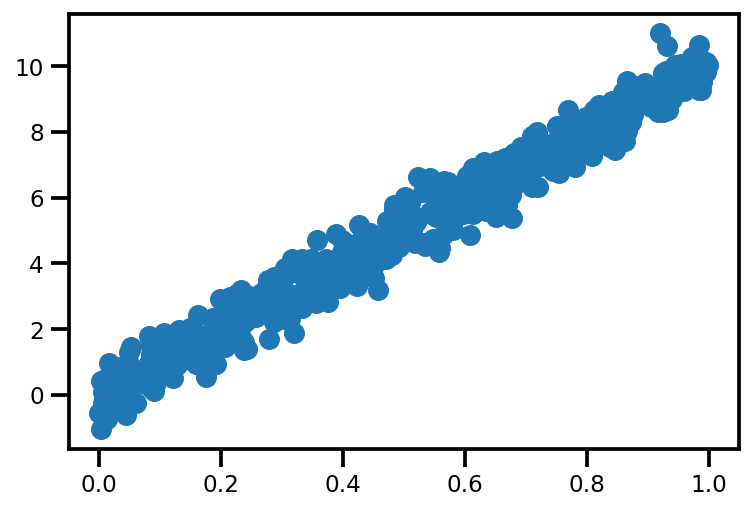

In [2]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
n_features = 1
noise_y = 0.5

X = rng.rand(n_samples, n_features)
Y = 10 * X + noise_y * rng.randn(n_samples, n_features)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## Similarity Measures

## Similarity - Kernel-Based

In [6]:
# initialize kernel
lin_kern = jax.partial(kernel_matrix, linear_kernel)


#### HSIC

In [7]:
import objax

# initialize HSIC
hsic_clf = HSIC(lin_kern, lin_kern)

hsic_val = hsic_clf(X, Y)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.6760


##### Isotropic Scaled Data

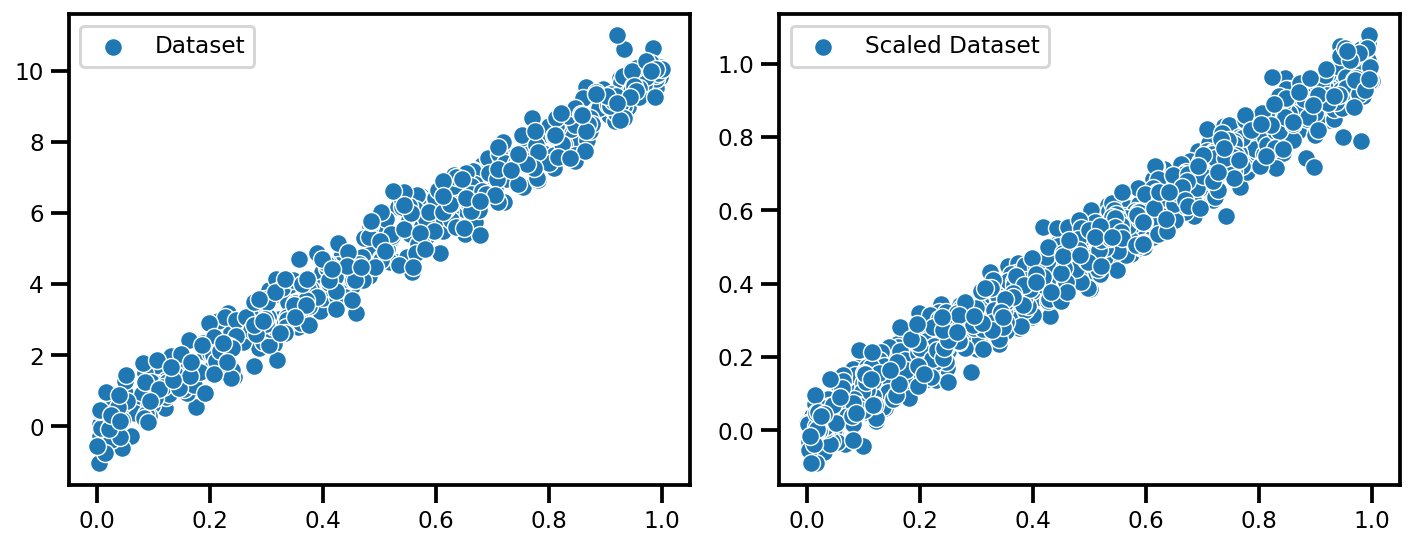

In [8]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 1000

X_s = rng.rand(n_samples, 1)
Y_s = X_s + 0.05 * rng.randn(n_samples, 1)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.scatterplot(x=X_s.squeeze(), y=Y_s.squeeze(), ax=ax[1], label='Scaled Dataset');
sns.scatterplot(x=X.squeeze(), y=Y.squeeze(), ax=ax[0], label='Dataset');
plt.tight_layout()
plt.show()

In [9]:
# initialize HSIC
hsic_clf = HSIC(lin_kern, lin_kern)

hsic_val = hsic_clf(X_s, Y_s)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.0065


#### Centered Kernel Alignment

In [10]:
# initialize HSIC
cka_clf = CKA(lin_kern, lin_kern)

cka_val = cka_clf(X, Y)

print(f"CKA: {cka_val:.4f}")

cka_val = cka_clf(X_s, Y_s)

print(f"CKA (scaled): {cka_val:.4f}")

CKA: 0.9703
CKA (scaled): 0.9747


### HSIC, RBF Kernel

In [11]:
%%time
from jaxkern.kernels.stationary import RBF

# estimate the length scale
length_scale_X = estimate_sigma_median(X_s[:1000], X_s[:1000])
length_scale_Y = estimate_sigma_median(Y_s[:1000], Y_s[:1000])

# create the kernel matrix
rbf_kern_X = jax.partial(kernel_matrix, jax.partial(rbf_kernel, length_scale_X, 1.0))
rbf_kern_Y = jax.partial(kernel_matrix, jax.partial(rbf_kernel, length_scale_Y, 1.0))


hsic_rbf_clf = HSIC(
    kernel_X=rbf_kern_X, 
    kernel_Y=rbf_kern_Y,
)

hsic_val = hsic_rbf_clf(X_s, Y_s)

print(f"HSIC (rbf): {hsic_val:.4f}")

HSIC (rbf): 0.0582
CPU times: user 1.46 s, sys: 127 ms, total: 1.58 s
Wall time: 1.35 s


In [12]:
%%time
cka_rbf_clf = CKA(
    kernel_X=rbf_kern_X, 
    kernel_Y=rbf_kern_Y,
)

cka_val = cka_rbf_clf(X_s, Y_s)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.7301
CPU times: user 143 ms, sys: 35.6 ms, total: 179 ms
Wall time: 67.9 ms


#### JIT Compilation

In [13]:
cka_rbf_clf_jitted = objax.Jit(cka_rbf_clf)

In [14]:
%%time
cka_val = cka_rbf_clf_jitted(X_s, Y_s)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.7301
CPU times: user 622 ms, sys: 14.3 ms, total: 637 ms
Wall time: 609 ms


In [15]:
%%time
cka_val = cka_rbf_clf_jitted(X_s, Y_s)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.7301
CPU times: user 39 ms, sys: 2.24 ms, total: 41.2 ms
Wall time: 22.9 ms


### Convenience Function (RBF)

Everyone tends to use the RBF kernel because it is the easiest to use. Especially in unsupervised scenarios where we cannot actually learn the kernel parameters.

In [16]:
from jaxkern.similarity.hsic import HSICRBF, CKARBF

In [17]:
%%time

hsic_rbf_clf = HSICRBF(
    sigma_x=estimate_sigma_median, 
    sigma_y=estimate_sigma_median,
)

hsic_val = hsic_rbf_clf(X, Y)

print(f"HSIC (rbf): {hsic_val:.4f}")

hsic_val = hsic_rbf_clf(X_s, Y_s)

print(f"HSIC (rbf): {hsic_val:.4f}")

HSIC (rbf): 0.0215
HSIC (rbf): 0.0583
CPU times: user 2.19 s, sys: 183 ms, total: 2.38 s
Wall time: 1.91 s


In [35]:
%%time

nhsic_rbf_clf = CKARBF(
    sigma_x=estimate_sigma_median, 
    sigma_y=estimate_sigma_median,
    bias=True
)

nhsic_val = nhsic_rbf_clf(X, Y)
print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)
print(f"nHSIC (rbf): {nhsic_val:.4f}")


nhsic_val = nhsic_rbf_clf(X_s, Y_s)
print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)

print(f"nHSIC (rbf): {nhsic_val:.4f}")

0.059270773 6.1342826
nHSIC (rbf): 0.4787
0.058924634 0.059522547
nHSIC (rbf): 0.7301
CPU times: user 1.41 s, sys: 203 ms, total: 1.61 s
Wall time: 1.34 s


In [36]:
from jaxkern.kernels.sigma import estimate_sigma_median_kth

In [50]:
est_k = jax.partial(estimate_sigma_median_kth, percent=0.8)
nhsic_rbf_clf = CKARBF(
    sigma_x=est_k, 
    sigma_y=est_k,
    bias=False
)

nhsic_val = nhsic_rbf_clf(X, Y)
print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)
print(f"nHSIC (rbf): {nhsic_val:.4f}")

nhsic_rbf_clf = CKARBF(
    sigma_x=est_k, 
    sigma_y=est_k,
    bias=False
)
nhsic_val = nhsic_rbf_clf(X_s, Y_s)
print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)

print(f"nHSIC (rbf): {nhsic_val:.4f}")

0.28078377 27.465548
nHSIC (rbf): 0.2589
0.27845788 0.26891446
nHSIC (rbf): 0.9594


## HSIC, RBF Sampler

In [61]:
n_samples = 10_000

X_s = rng.rand(n_samples, 1)
Y_s = X_s + 0.05 * rng.randn(n_samples, 1)

X_s = np.array(X_s)
Y_s = np.array(Y_s)


length_scale_X = estimate_sigma_median(X_s[:1000], X_s[:1000])
length_scale_Y = estimate_sigma_median(Y_s[:1000], Y_s[:1000])


In [62]:
%%time


n_rff = 100

hsic_rff_clf = HSICRBFSampler(
    length_scale_X=estimate_sigma_median, 
    length_scale_Y=estimate_sigma_median,
    n_rff=n_rff
)



hsic_val = hsic_rff_clf(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

TypeError: 'RandomState' object is not callable

#### Jit Compilation

In [42]:
hsic_rff_clf_jitted = objax.Jit(hsic_rff_clf, hsic_rff_clf.vars())

In [43]:
%%time

hsic_val = hsic_rff_clf_jitted(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0436
CPU times: user 3.15 s, sys: 66.2 ms, total: 3.22 s
Wall time: 3.27 s


In [44]:
%%time

hsic_val = hsic_rff_clf_jitted(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0436
CPU times: user 750 ms, sys: 11.1 ms, total: 761 ms
Wall time: 763 ms


In [35]:
%%time



n_rff = 100

cka_rff_clf = CKARBFSampler(
    length_scale_X=estimate_sigma_median, 
    length_scale_Y=estimate_sigma_median,
    n_rff=n_rff
)
cka_val = cka_rff_clf(X_s, Y_s)

print(f"CKA (rff): {cka_val:.4f}")

CKA (rff): 0.5677
CPU times: user 849 ms, sys: 44.5 ms, total: 893 ms
Wall time: 999 ms


#### Jit Compilation

In [36]:
cka_rff_clf_jitted = objax.Jit(cka_rff_clf)

In [37]:
%%time

cka_val = cka_rff_clf_jitted(X_s, Y_s)

print(f"CKA (rff): {cka_val:.4f}")

CKA (rff): 0.5677
CPU times: user 3.23 s, sys: 57.5 ms, total: 3.29 s
Wall time: 3.35 s


In [39]:
%%time

cka_val = cka_rff_clf_jitted(X_s, Y_s)

print(f"CKA (rff): {cka_val:.4f}")

CKA (rff): 0.5677
CPU times: user 733 ms, sys: 10.4 ms, total: 744 ms
Wall time: 744 ms
